# Libraries and Dependencies

In [ ]:
!pip install pandas
!pip install numpy
!pip install transformers
!pip install torch torchvision

# install the sentencepiece library
# NOTE: if installing for the first time and if using google colab, restart the runtime after installation
!pip install sentencepiece

# Imports

In [40]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime as dt
import random
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import RandomSampler, SequentialSampler, TensorDataset, DataLoader
from transformers import RobertaForSequenceClassification, RobertaTokenizer, BertForSequenceClassification, BertTokenizer,AdamW
from transformers import DebertaForSequenceClassification, AlbertForSequenceClassification, ElectraForSequenceClassification
from transformers import DebertaTokenizer, AlbertTokenizer, ElectraTokenizer
from sklearn.metrics import f1_score, classification_report

# Pre-trained Models

In [2]:
# Use GPU if available else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

# import the pre-trained models
modelB = BertForSequenceClassification.from_pretrained("bert-base-uncased").to(device)
modelR = RobertaForSequenceClassification.from_pretrained("roberta-base").to(device)
modelE = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator").to(device)
modelA = AlbertForSequenceClassification.from_pretrained("albert-base-v2").to(device)
modelD = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base").to(device)

# Tokenizers to be used
tokenizerB = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizerR = RobertaTokenizer.from_pretrained("roberta-base")
tokenizerE = ElectraTokenizer.from_pretrained("google/electra-base-discriminator")
tokenizerA = AlbertTokenizer.from_pretrained("albert-base-v2")
tokenizerD = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

print("Model ready to be fine-tuned!!!")

Device:  cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight


Model ready to be fine-tuned!!!


# Data Loading

In [13]:
def loadAugmentedData():

  trainData = pd.read_json("./Augmented_train.jsonl", lines=True, orient="records")
  valData = pd.read_json("./Augmented_val.jsonl", lines=True, orient="records")
  
  # Train 
  trainPassages = trainData.passage.values
  trainQuestions = trainData.question.values
  trainAnswers = trainData.label.values

  # Validation
  valPassages = valData.passage.values
  valQuestions = valData.question.values
  valAnswers = valData.label.values

  return trainQuestions, trainPassages, trainAnswers, valQuestions, valPassages, valAnswers

trainQuestions, trainPassages, trainAnswers, valQuestions, valPassages, valAnswers = loadAugmentedData()

# Tokenization

In [6]:
def tokenizeData(tokenizer, questions, passages, max_length=256):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
      tokenizedData = tokenizer.encode_plus(question, passage, max_length=max_length, padding='max_length', truncation="longest_first")
      tokenizedQP = tokenizedData["input_ids"]
      attentionMask = tokenizedData["attention_mask"]

      input_ids.append(tokenizedQP)
      attention_masks.append(attentionMask)

    return np.array(input_ids), np.array(attention_masks)


# Building Dataloaders

In [29]:
# Building the Dataloaders

def buildDataLoaders(batchSize, trainFeatures, valFeatures):
  trainTensors = [torch.tensor(feature, dtype=torch.long) for feature in trainFeatures]
  valTensors = [torch.tensor(feature, dtype=torch.long) for feature in valFeatures]

  trainDataset = TensorDataset(*trainTensors)
  valDataset = TensorDataset(*valTensors)

  trainSampler = RandomSampler(trainDataset)
  valSampler = SequentialSampler(valDataset)

  trainDataloader = DataLoader(trainDataset, sampler=trainSampler, batch_size=batchSize)
  valDataloader = DataLoader(valDataset, sampler=valSampler, batch_size=batchSize)

  return trainDataloader, valDataloader

# Fine-Tuning

In [41]:
# Fine-tune the model on downstream task: BoolQ
def train(numEpochs, gradSteps, model, optimizer, trainDataLoader, type="regular"):
    
  trainLossHistory = []

  for _ in tqdm(range(numEpochs), desc="Training Epoch's"):

    # Train the model for fine-tuning
    epochTrainLoss = 0 # Cumulative loss
    model.train()
    model.zero_grad()

    for step, batch in enumerate(trainDataLoader):
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)     
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

        loss = outputs[0]
        loss = loss / gradSteps
        epochTrainLoss += loss.item()
        loss.backward()
        
        if (step + 1) % gradSteps == 0: # Gradient accumulation is over
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
          optimizer.step()
          model.zero_grad()

    epochTrainLoss = epochTrainLoss / len(trainDataLoader)          
    trainLossHistory.append(epochTrainLoss)

  if not os.path.exists("./models/"):
    os.mkdir("./models/")
  
  if not os.path.exists("./models/" + type + "/"):
    os.mkdir("./models/" + type + "/")
    
  if model == modelB:
    torch.save(model, "./models/" + type + "/bert.pt")

  sns.set()
  plt.plot(trainLossHistory, label="Train_Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training Loss")
  plt.legend()
  plt.xticks(np.arange(0, 3))
  plt.show()

# Evaluation

In [42]:
# Evaluation on validation set
def eval(valDataLoader, numEpochs, model):
    valAccuracy = []
    valF1 = []

    for _ in tqdm(range(numEpochs), desc="Validation Epoch's"):
      epochValAcc = 0
      epochValF1 = 0
      model.eval()
      for batch in valDataLoader:
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2]
                    
        with torch.no_grad():        
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
        epochValF1 += f1_score(predictions, labels)
        epochValAcc += np.sum(predictions == labels) / len(labels)

      epochValAcc = epochValAcc / len(valDataLoader)
      epochValF1 = epochValF1 / len(valDataLoader)
      valAccuracy.append(epochValAcc)
      valF1.append(epochValF1)

    acc = sum(valAccuracy) / len(valAccuracy)
    f1 = sum(valF1) / len(valF1)
    print("\nVal Accuracy:", acc)
    print("Val F1:", f1)

    
    plt.plot(valAccuracy, label="Val_Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy")
    plt.legend()
    plt.xticks(np.arange(0, 3))
    plt.show()

    return acc, f1

# Predictions

In [43]:
# Making Predictions on the test set
def predict(question, passage, max_length=512):
  sequence = tokenizer.encode_plus(question, passage, max_length=max_length,
                                   padding='max_length', truncation="longest_first" 
                                   , return_tensors="pt")['input_ids'].to(device)
  
  logits = model(sequence)[0]
  probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]
  proba_yes = round(probabilities[1], 2)
  proba_no = round(probabilities[0], 2)
  return (f"Question: {question}, Yes: {proba_yes}, No: {proba_no}")

# for i in range(len(testPassages)):
#   testPred.write(f"\n{i}" + ": " + predict(testQuestions[i], testPassages[i]))
  



In [44]:
def runModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, type="Regular"):

  print("Fine-tuning and evaluating the model...")
  # Tokenize the data
  trainIds, trainAttMasks = tokenizeData(tokenizer, trainQuestions, trainPassages, maxSeqLength)
  valIds, valAttMasks = tokenizeData(tokenizer, valQuestions, valPassages, maxSeqLength)
  # testIds, testAttMasks = tokenizeData(tokenizer, testQuestions, testPassages, maxSeqLength)

  trainFeatures = (trainIds, trainAttMasks , trainAnswers)
  valFeatures = (valIds, valAttMasks, valAnswers)
  # testFeatures = (testIds, testAttMasks)

  # Build the Dataloaders
  trainDataLoader, valDataLoader = buildDataLoaders(batchSize, trainFeatures, valFeatures)

  # Fine-tune
  train(numEpochs, gradSteps, model, optimizer, trainDataLoader, type)

  # Evaluate
  acc, f1 = eval(valDataLoader, numEpochs, model)

  # Writing results to a file
  if model == modelB:
    results = "resultsBERT.txt"
  elif model == modelR:
    results = "resultRoBERTa.txt" 
  elif model == modelE:
    results = "resultELECTRA.txt"
  elif model == modelA:
    results = "resultALBERT.txt"
  elif model == modelD:
    results = "resultDeBERTa.txt"
  
  resultFile = open(results, "w")
  resultFile.write(f"Validation Accuracy: {round(acc, 2)}, Validation F1: {round(f1,2)}")



In [ ]:
def loadModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, type="Regular"):

  print("Loading saved models for evaluation...")
  # Tokenize the data
  trainIds, trainAttMasks = tokenizeData(tokenizer, trainQuestions, trainPassages, maxSeqLength)
  valIds, valAttMasks = tokenizeData(tokenizer, valQuestions, valPassages, maxSeqLength)
  # testIds, testAttMasks = tokenizeData(tokenizer, testQuestions, testPassages, maxSeqLength)

  trainFeatures = (trainIds, trainAttMasks , trainAnswers)
  valFeatures = (valIds, valAttMasks, valAnswers)
  # testFeatures = (testIds, testAttMasks)

  # Build the Dataloaders
  trainDataLoader, valDataLoader = buildDataLoaders(batchSize, trainFeatures, valFeatures)

  # Evaluate
  acc, f1 = eval(valDataLoader, numEpochs, model)

  # Writing results to a file
  if model == modelB:
    results = "resultsBERT.txt"
  elif model == modelR:
    results = "resultRoBERTa.txt" 
  elif model == modelE:
    results = "resultELECTRA.txt"
  elif model == modelA:
    results = "resultALBERT.txt"
  elif model == modelD:
    results = "resultDeBERTa.txt"
  
  resultFile = open(results, "w")
  resultFile.write(f"Validation Accuracy: {round(acc, 2)}, Validation F1: {round(f1,2)}")



In [54]:
def runBERT(model, tokenizer, optimizer, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType):
  print("\nRunning BERT model")
  optimizer = AdamW(model.parameters(), lr=learningRate)
  runModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

def runROBERTA(model, tokenizer, optimizer, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType):
  print("\nRunning RoBERTa model")
  optimizer = AdamW(model.parameters(), lr=learningRate)
  runModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

def runELECTRA(model, tokenizer, optimizer, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType):
  print("\nRunning ELECTRA model")
  optimizer = AdamW(model.parameters(), lr=learningRate)
  runModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

def runALBERT(model, tokenizer, optimizer, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType):
  print("\nRunning ALBERT model")
  optimizer = AdamW(model.parameters(), lr=learningRate)
  runModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

def runDEBERTA(model, tokenizer, optimizer, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType):
  print("\nRunning DeBERTa model")
  optimizer = AdamW(model.parameters(), lr=learningRate)
  runModel(model, tokenizer, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

def runALL(optimizer, batchSize, learningRate, maxSeqLength, gradSteps, numEpochs, runType):
  
  print("\nYou have selected to run all models")

  runBERT(modelB, tokenizerB, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)
  runROBERTA(modelR, tokenizerR, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)
  runELECTRA(modelE, tokenizerE, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)
  runALBERT(modelA, tokenizerA, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)
  runDEBERTA(modelD, tokenizerD, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)
  

# Testing

In [55]:
print("Models Available:\n 1: BERT \n 2: RoBERTa \n 3: ELECTRA \n 4: ALBERT \n 5: DeBERTa \n 6: All\n")
choice = int(input("Select the model you'd like to run:"))

learningRate = float(input("Please enter a learning rate:(e.g. 1e-5)"))
batchSize = int(input("Please enter batch size:(e.g. 8)"))
numEpochs = int(input("Please enter the number of epochs:(e.g. 3)"))
maxSeqLength = int(input("Please enter the maximum sequence length:(e.g. 128)"))
gradSteps = int(input("Please enter the number of gradient steps:(e.g. 3)"))
runType = input("Please input the run type: (e.g. augDhawal)")

if choice == 1:
  runBERT(modelB, tokenizerB, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

elif choice == 2:
  runROBERTA(modelR, tokenizerR, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

elif choice == 3:
  runELECTRA(modelE, tokenizerE, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

elif choice == 4:
  runALBERT(modelA, tokenizerA, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

elif choice == 5:
  runDEBERTA(modelD, tokenizerD, optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

elif choice == 6:
  runAll(optimizer, batchSize, maxSeqLength, gradSteps, numEpochs, runType)

Models Available:
 1: BERT 
 2: RoBERTa 
 3: ELECTRA 
 4: ALBERT 
 5: DeBERTa 
 6: All



KeyboardInterrupt: ignored

Validation Epoch's:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
Validation Epoch's: 100%|██████████| 3/3 [01:15<00:00, 25.18s/it]


Val Accuracy: 0.71393492940454
Val F1: 0.7105586249232622


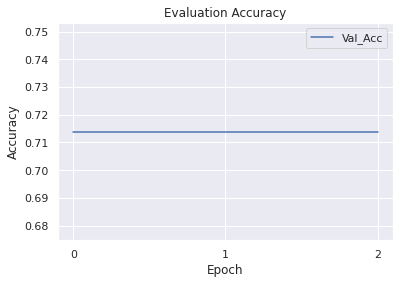

In [51]:
model = torch.load("./models/augDhawal/bert.pt")

trainIds, trainAttMasks = tokenizeData(tokenizerB, trainQuestions, trainPassages, 128)
valIds, valAttMasks = tokenizeData(tokenizerB, valQuestions, valPassages, 128)

trainFeatures = (trainIds, trainAttMasks , trainAnswers)
valFeatures = (valIds, valAttMasks, valAnswers)

trainDataLoader, valDataLoader = buildDataLoaders(3, trainFeatures, valFeatures)
acc, f1 = eval(valDataLoader, 3, model)